# Gradient-Boosting Decision Tree (GBDT)

Gradient-boosting differs from AdaBoost due to the following reason: instead of assigning weights to specific samples, GBDT will fit a decision tree on the residuals error (hence the name "gradient") of the previous tree. 

Therefore, each new tree in the ensemble predicts the error made by the previous learner instead of predicting the target directly.

In this section we will provide some intuition about the way learners are combined to give the final prediction. In this regard, let's go back to our regression problem which is more intuitive for demonstrating the underlying machinery.

In [1]:
import pandas as pd
import numpy as np

# Create random number generator that will be used to set the randomness
rng = np.random.RandomState(0)

In [4]:
def generate_data(n_samples=50):
    """Generate synthetic dataset. Returns `data_train`, `data_test`,
    `target_train`."""
    x_max, x_min = 1.4, -1.4
    len_x = x_max - x_min
    x = rng.rand(n_samples) * len_x - len_x / 2
    noise = rng.randn(n_samples) * 0.3
    y = x ** 3 - 0.5 * x ** 2 + noise

    data_train = pd.DataFrame(x, columns=["Feature"])
    data_test = pd.DataFrame(np.linspace(x_max, x_min, num=300),
                             columns=["Feature"])
    target_train = pd.Series(y, name="Target")
    return data_train, data_test, target_train


In [5]:
data_train, data_test, target_train = generate_data()

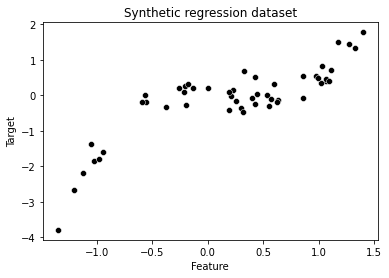

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(x=data_train["Feature"], y=target_train,
               color='black')
plt.title("Synthetic regression dataset");

As we previously discussed, boosting will be based on assembling a sequence of learners. We will start by creating a decision tree regressor. We will set the depth of the tree so that the resulting learner will underfit the data.

In [8]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=3, random_state=0)
tree.fit(data_train, target_train)

DecisionTreeRegressor(max_depth=3, random_state=0)

In [9]:
target_train_predicted = tree.predict(data_train)
target_test_predicted = tree.predict(data_test)

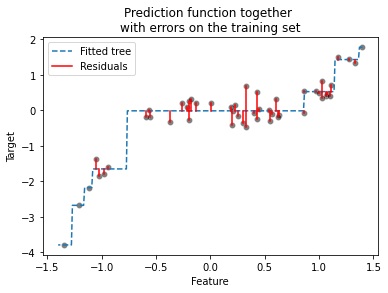

In [10]:
# plot the data
sns.scatterplot(x=data_train["Feature"], y=target_train, color="black",
                alpha=0.5)
# plot the predictions
line_predictions = plt.plot(data_test, target_test_predicted, "--")

# plot the residuals
for value, true, predicted in zip(data_train["Feature"],
                                  target_train,
                                  target_train_predicted):
    lines_residuals = plt.plot([value, value], [true, predicted], color="red")

plt.legend([line_predictions[0], lines_residuals[0]],
           ["Fitted tree", "Residuals"])
_ = plt.title("Prediction function together \nwith errors on the training set")